# Petition for Rulemaking—NYC Idling
## Source data analysis

<br>

Author: Nikita Bogdanov (nmbogdan@alumni.stanford.edu)

Petition submitted to the NYC Department of Environmental Protection May 16, 2023.

Data pulled May 5, 2023 and available in [`5_5_2023_DEP_filter.csv`](https://www.dropbox.com/s/vfhcd8b0gsv0gym/5_5_2023_DEP_filter.csv?dl=0).

Most tables + figure data was transferred to [this](https://docs.google.com/spreadsheets/d/16Ypi7b4k7VorWqBJKioJXu496ccHEr1e6fZdV2sfyPk/edit#gid=942470366) Google Sheet, from which most tables and figures were transferred to [Overleaf LaTex](https://www.overleaf.com/read/pxfygpkghdrg), where the project writeup is viewable today.

<br>

---


In [1]:
import pandas as pd
import datetime as dt
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load

In [2]:
# Load most current data via API
# API documentation available at https://dev.socrata.com/
#####

# app_token = 'APP_TOKEN'

# offset = 0
# limit = 45000
# agency = 'DEP - BUREAU OF ENV. COMPLIANC'

# api_df = pd.DataFrame()

# for i in range(380):
    
#     api_url = f'https://data.cityofnewyork.us/resource/jz4z-kudi.json?$limit={limit}&$offset={offset}&$order=ticket_number&issuing_agency={agency}'
#     headers = {'X-App-Token': app_token}
#     response = requests.get(api_url, headers=headers)

#     temp = pd.DataFrame(response.json())
    
#     api_df = pd.concat([api_df, temp])
    
#     if temp.shape[0] == 0:
#         break
        
#     offset += limit
    
#     if i % 1 == 0:
#         print(offset)

# api_df.to_csv(f'{dt.datetime.today().strftime("%m_%d_%Y")}_DEP_filter.csv', index=False)


In [3]:
# Load legacy data (for analysis reproducibility)
api_df = pd.read_csv('5_5_2023_DEP_filter.csv', low_memory=False)

## Clean and wrangle

In [4]:
# All first-charge codes across violations
api_df[api_df['charge_1_code_section'].str.contains('163') & 
       api_df['charge_1_code_section'].str.contains('24')]['charge_1_code_section'].value_counts()

24 -163                78894
24-163 F                5663
A.C. 24-163             1367
24-163.                   12
A.C. 24-163.3(B)(2)        2
A.C 24-163                 2
A.C. 24-163(B)(2)          1
24-163(F)                  1
Name: charge_1_code_section, dtype: int64

In [5]:
# We're interested in tickets for violations of Sections 24-163 or 24-163(f) only
idling_codes = ['24 -163', '24-163 F', 'A.C. 24-163', '24-163.', 'A.C 24-163', '24-163(F)']

dff = api_df[api_df['charge_1_code_section'].isin(idling_codes)].copy()

dff.reset_index(inplace=True)

dff['hearing_date'] = pd.to_datetime(dff['hearing_date'])
dff['violation_date'] = pd.to_datetime(dff['violation_date'])
dff['penalty_imposed'] = dff['penalty_imposed'].fillna(0).astype(int)
dff['paid_amount'] = dff['paid_amount'].fillna(0).astype(int)

In [6]:
# Drop tickets with null violation dates or null hearing dats
to_drop = dff[dff['violation_date'].isna() | dff['hearing_date'].isna()]

print(f"Dropping {to_drop.shape[0]} entries, of which {to_drop[to_drop['penalty_imposed'] > 0].shape[0]} have non-zero penalties.")

dff.drop(to_drop.index, inplace=True)


Dropping 73 entries, of which 49 have non-zero penalties.


In [7]:
def categorize_fines(fine):
    """
    Based on fine, categorize whether the ticket is a first-time, second-time, 
    or third-and-subsequent ticket. Note that this method works only for violations
    of Sections 24-163 and 24-163(f), under the penalty schedule in place as of
    5/5/2023.
    """
    
    if fine == 0:
        return 'na'
    
    if fine == 350 or fine == 1000:
        return '1'
    
    if fine == 440 or fine == 1500:
        return '2'
    
    if fine == 600 or fine == 2000:
        return '3'
    
    return '-1'

In [8]:
# Basic data type transformations
dff['cacp'] = dff['violation_details'].str.lower().str.contains('citizen').astype(bool)

dff['hearing_year'] = dff['hearing_date'].dt.year
dff['violation_year'] = dff['violation_date'].dt.year

dff['violation_dt'] = pd.to_datetime(dff['violation_date'].astype(str) + ' ' + dff['violation_time'], 
                                     infer_datetime_format=True)
dff['violation_hour'] = dff['violation_dt'].dt.hour
dff['violation_dow'] = dff['violation_dt'].dt.weekday

dff['processing_time'] = (dff['hearing_date'] - dff['violation_date']).dt.days

dff['fine_type'] = dff['penalty_imposed'].apply(lambda x: categorize_fines(x))

In [9]:
def extract_license_plate(input_string):
    
    pattern = r'\b([A-Z]{2})\s*license\s*plate\s*([A-Z0-9]+)\b'
    
    input_string = input_string.values[0]
        
    match = re.search(pattern, input_string, re.IGNORECASE)
    
    state = ''
    license_plate = ''
    
    if match:
        state = match.group(1)
        license_plate = match.group(2)
        
        if len(state) != 2:
            state = 'err'

        if len(license_plate) < 6 or len(license_plate) > 9 or license_plate == 'NUMBER':
            license_plate = 'err'
        
    return [state, license_plate]

In [10]:
# Extract license plate info
dff['violation_details'] = dff['violation_details'].astype(str)

dff[['license_plate_state', 
     'license_plate_number']] = dff[['violation_details']].apply(lambda x: extract_license_plate(x), 
                                                                 axis=1, 
                                                                 result_type='expand')

dff['license_plate'] = dff['license_plate_state'] + '_' + dff['license_plate_number']

dff['license_plate'] = dff['license_plate'].str.replace('^_$|.*err.*', 'err', regex=True)

print(f"Entries with invalid plates: {dff[dff['license_plate'].str.len() == 3].shape[0]:,}.")

Entries with invalid plates: 15,362.


In [11]:
def standardize_respondents(n):
    """
    Based on a non-exhaustive list of duplicate or near-duplicate respondents.
    """
    
    n = str(n)
    
    if bool(re.search("amazon", n.lower())):
        return 'AMAZON'
    
    if bool(re.search("con edison|consolidated edison|coned", n.lower())):
        return 'CON ED'
    
    if bool(re.search("merchants fleet|merchants automotive group", n.lower().replace("'", ""))):
        return "MERCHANT'S FLEET"
    
    if bool(re.search("verizon", n.lower())):
        return "VERIZON"
    
    if bool(re.search("u-haul", n.lower())):
        return "U-HAUL"
    
    if bool(re.search("fedex|federal express", n.lower())):
        return "FEDEX"
    
    if bool(re.search("edge auto", n.lower())):
        return "EDGE AUTO"
    
    if bool(re.search("ups|united parcel service", n.lower())):
        return "UPS"
    
    return n

In [12]:
dff['respondent_last_name'] = dff['respondent_last_name'].apply(lambda x: standardize_respondents(x))

## Analysis

### Filter to recent years, only tickets with fines, only violations of 24-163

In [13]:
df = dff[(dff['penalty_imposed'] > 0) & dff['hearing_year'].between(2020, 2022)]

df.shape

(26184, 74)

In [14]:
df['charge_1_code_section'].value_counts()

24 -163     24399
24-163 F     1785
Name: charge_1_code_section, dtype: int64

In [15]:
# Filter down to tickets for violations of 24-163 only, i.e., exclude tickets for violations of 24-163(f)
df = df[df['charge_1_code_section'] == '24 -163']

df.shape

(24399, 74)

### Basic data exploration

In [16]:
df.describe()

,index,balance_due,violation_location_floor,total_violation_amount,penalty_imposed,paid_amount,additional_penalties_or_late_fees,charge_1_infraction_amount,violation_location_block_no,violation_location_lot_no,charge_2_infraction_amount,charge_3_infraction_amount,charge_4_infraction_amount,charge_5_infraction_amount,charge_6_infraction_amount,hearing_year,violation_year,violation_hour,violation_dow,processing_time
count,24399.000000,24399.000000,0.0,24399.000000,24399.000000,24399.000000,24399.000000,24399.000000,14685.000000,14696.000000,102.000000,0.0,0.0,0.0,0.0,24399.000000,24399.000000,24399.000000,24399.000000,24399.000000
mean,102479.679987,298.081971,NaN,360.945940,628.335956,426.427313,114.382967,359.995492,1203.921144,1091.621121,222.941176,NaN,NaN,NaN,NaN,2021.195541,2020.340055,12.421124,2.180909,320.048691
std,12476.222028,571.704240,NaN,43.502757,354.260306,405.158681,155.246560,46.008612,1496.230369,2611.157689,224.510858,NaN,NaN,NaN,NaN,0.774895,0.918776,3.307950,1.637506,155.381045
min,53973.000000,-1950.000000,NaN,350.000000,163.000000,0.000000,-1400.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,2020.000000,2018.000000,0.000000,0.000000,35.000000
25%,93638.500000,0.000000,NaN,350.000000,350.000000,350.000000,0.000000,350.000000,625.000000,11.000000,0.000000,NaN,NaN,NaN,NaN,2021.000000,2020.000000,10.000000,1.000000,218.000000
50%,100817.000000,0.000000,NaN,350.000000,350.000000,350.000000,0.000000,350.000000,1003.000000,32.000000,350.000000,NaN,NaN,NaN,NaN,2021.000000,2020.000000,12.000000,2.000000,285.000000
75%,113969.000000,0.000000,NaN,350.000000,1000.000000,420.000000,300.000000,350.000000,1163.000000,61.000000,440.000000,NaN,NaN,NaN,NaN,2022.000000,2021.000000,14.000000,3.000000,384.000000
max,130175.000000,3250.000000,NaN,790.000000,2500.000000,3900.000000,1000.000000,600.000000,20112.000000,9999.000000,600.000000,NaN,NaN,NaN,NaN,2022.000000,2022.000000,23.000000,6.000000,1471.000000


In [17]:
df.query('`penalty_imposed` > 0').groupby('violation_year')['processing_time'].mean().reset_index()

,violation_year,processing_time
0,2018,665.125000
1,2019,449.195071
2,2020,302.966498
3,2021,271.612941
4,2022,266.642458


In [18]:
df[df['penalty_imposed'] > 0]['hearing_status'].value_counts()

PAID IN FULL            17140
DEFAULTED                5226
HEARING COMPLETED        1666
APPEAL DECIS RENDERD      294
DOCKETED                   62
STIP NEEDS REVIEW           4
RESCHEDULED                 2
ACCEPTED FOR APPEAL         2
ASSIGNED TO APPEALS         2
ASSIGNED                    1
Name: hearing_status, dtype: int64

In [19]:
df[df['penalty_imposed'] > 0]['hearing_result'].value_counts()

DEFAULTED       9554
STIPULATED      8090
IN VIOLATION    6754
ADJOURNED          1
Name: hearing_result, dtype: int64

In [20]:
df['cacp'].value_counts()

True     24329
False       70
Name: cacp, dtype: int64

In [21]:
df[df["paid_amount"] > df['penalty_imposed']].shape

(3807, 74)

In [22]:
zip_code = (df.groupby('violation_location_zip_code')['penalty_imposed']
              .sum()
              .reset_index()
              .sort_values(by='penalty_imposed', ascending=False))

zip_code['pct_of_total'] = zip_code['penalty_imposed']/df['penalty_imposed'].sum()
zip_code['cum_pct'] = zip_code['pct_of_total'].cumsum()

zip_code.head()

,violation_location_zip_code,penalty_imposed,pct_of_total,cum_pct
34,10036,1576080,0.102805,0.102805
21,10023,1221980,0.079708,0.182513
8,10009,816290,0.053245,0.235758
16,10018,762510,0.049737,0.285495
2,10002,647940,0.042264,0.327759


In [23]:
(df.groupby(['violation_dow', 'violation_hour'])['penalty_imposed']
   .sum()
   .reset_index()
   .sort_values(by='penalty_imposed', ascending=False)).head()

,violation_dow,violation_hour,penalty_imposed
60,2,12,547340
36,1,12,496590
12,0,12,471000
61,2,13,431890
37,1,13,427950


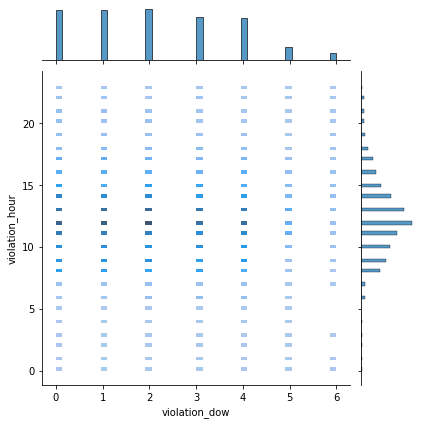

In [24]:
sns.jointplot(data=df, x='violation_dow', y='violation_hour', kind="hist",)

In [25]:
(pd.pivot_table(df, 
                index='hearing_result', 
                values=['ticket_number', 'penalty_imposed'],
                aggfunc={'ticket_number': len, 'penalty_imposed': sum})
 .reset_index()
 .sort_values(by='ticket_number', ascending=False))

,hearing_result,penalty_imposed,ticket_number
1,DEFAULTED,9987000,9554
3,STIPULATED,2917980,8090
2,IN VIOLATION,2424789,6754
0,ADJOURNED,1000,1


In [26]:
df['penalty_imposed'].value_counts().reset_index()

,index,penalty_imposed
0,350,13804
1,1000,8906
2,440,698
3,1500,435
4,600,333
5,2000,214
6,750,1
7,351,1
8,163,1
9,250,1


In [27]:
(df.query("license_plate != 'err'")
   .groupby('license_plate_state')['ticket_number']
   .count()
   .reset_index()
   .sort_values(by='ticket_number', ascending=False)
   .head(10))

,license_plate_state,ticket_number
32,NY,12198
30,NJ,3753
8,FL,732
14,IN,477
36,PA,196
13,IL,174
39,TX,116
5,CT,91
2,AZ,89
19,MD,81


In [28]:
(df.query("license_plate_number == 'err'")
   .groupby('license_plate_state')['ticket_number']
   .count()
   .reset_index()
   .sort_values(by='ticket_number', ascending=False)
   .head(10))

,license_plate_state,ticket_number
21,NY,3419
19,NJ,970
25,PA,77
4,FL,41
3,CT,32
9,MA,31
26,RI,24
16,NC,22
29,TX,21
30,VA,14


In [29]:
(df.query("license_plate != 'err'")
   .groupby('license_plate')['ticket_number']
   .count()
   .reset_index()
   .sort_values(by='ticket_number', ascending=False)
   .head(10))

,license_plate,ticket_number
296,FL_QEFS36,52
3611,NJ_XKZE45,47
3468,NJ_XKEY75,46
339,FL_QIAM21,45
314,FL_QEGG27,43
340,FL_QIAM22,41
226,FL_15AAIW,35
309,FL_QEGB73,32
280,FL_QBXE28,30
313,FL_QEGG26,30


In [30]:
(df.groupby('respondent_last_name')['license_plate']
   .nunique()
   .reset_index()
   .sort_values(by='license_plate', ascending=False)).head(15)

,respondent_last_name,license_plate
2296,CON ED,548
10085,VERIZON,352
731,AMAZON,263
8919,SPECTRUM,156
3544,FEDEX,148
6329,MERCHANT'S FLEET,89
9952,UPS,74
9816,U-HAUL,73
7448,PENSKE TRUCK LEASING CO LP,58
8366,RYDER TRUCK RENTAL INC,53


In [31]:
plates = (df.query("license_plate != 'err'")
            .groupby('license_plate')['ticket_number']
            .count()
            .reset_index()
            .sort_values(by='ticket_number', ascending=False))

print(plates[plates['ticket_number'] > 1].shape, plates.shape)

(2575, 2) (13383, 2)


In [32]:
df[~df['respondent_first_name'].isna()].shape

(3707, 74)

### Data for tables + figures

#### Top offenders (2022) — sheet 1

In [33]:
comps = (pd.pivot_table(df.query('hearing_year == 2022'), 
                        index='respondent_last_name', 
                        values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                        aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len})
           .reset_index())

comps['pct_of_total_penalty'] = comps['penalty_imposed']/comps['penalty_imposed'].sum()
comps['pct_of_total_tickets'] = comps['ticket_number']/comps['ticket_number'].sum()

comps.sort_values(by='ticket_number', ascending=False, inplace=True)
comps['cum_pct_tickets'] = comps['pct_of_total_tickets'].cumsum()

comps.sort_values(by='penalty_imposed', ascending=False, inplace=True)
comps['cum_pct_penalty'] = comps['pct_of_total_penalty'].cumsum()

comps['pct_paid'] = comps['paid_amount']/comps['penalty_imposed']

comps['avg_penalty'] = comps['penalty_imposed']/comps['ticket_number']

comps.reset_index(drop=True, inplace=True)

In [34]:
comps.loc[:9]['penalty_imposed'].sum()/comps['penalty_imposed'].sum()

0.26160588995851536

In [35]:
comps.loc[:9]['ticket_number'].sum()

2443

In [36]:
comps.head(10)

,respondent_last_name,paid_amount,penalty_imposed,ticket_number,pct_of_total_penalty,pct_of_total_tickets,cum_pct_tickets,cum_pct_penalty,pct_paid,avg_penalty
0,AMAZON,716697,728140,651,0.111546,0.063968,0.063968,0.111546,0.984285,1118.494624
1,CON ED,210443,414330,620,0.063472,0.060922,0.124889,0.175018,0.507912,668.274194
2,MERCHANT'S FLEET,177055,177440,466,0.027183,0.045790,0.170679,0.202201,0.997830,380.772532
3,VERIZON,145180,146910,331,0.022506,0.032524,0.203203,0.224706,0.988224,443.836858
4,FEDEX,25150,56650,109,0.008678,0.010710,0.213914,0.233385,0.443954,519.724771
5,U-HAUL,17735,45400,47,0.006955,0.004618,0.233271,0.240340,0.390639,965.957447
6,UPS,17100,40890,49,0.006264,0.004815,0.228653,0.246604,0.418195,834.489796
7,SPECTRUM,37625,38450,101,0.005890,0.009924,0.223838,0.252494,0.978544,380.693069
8,EDGE AUTO,1905,31430,39,0.004815,0.003832,0.245161,0.257309,0.060611,805.897436
9,LABQ,0,28050,30,0.004297,0.002948,0.251842,0.261606,0.000000,935.000000


#### Value counts of imposed penalties — sheet 2

In [37]:
df['fine_type'].value_counts().reset_index()

,index,fine_type
0,1,22710
1,2,1133
2,3,547
3,-1,9


#### Number of respondents with _X_ violations — sheet 3

In [38]:
comps = (pd.pivot_table(df.query("hearing_year == 2022"), 
                        index='respondent_last_name', 
                        values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                        aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len})
           .reset_index())

comps.sort_values(by='penalty_imposed', ascending=False, inplace=True)

In [39]:
b = pd.pivot_table(comps, 
                   index='ticket_number', 
                   values=['respondent_last_name', 'penalty_imposed'], 
                   aggfunc={'respondent_last_name': len,
                            'penalty_imposed': sum}).reset_index()

b['pct_penalties_imposed'] = b['penalty_imposed']/b['penalty_imposed'].sum()

b['ticket_count'] = b['ticket_number']*b['respondent_last_name']
b['pct_tickets'] = b['ticket_count']/b['ticket_count'].sum()

b

,ticket_number,penalty_imposed,respondent_last_name,pct_penalties_imposed,ticket_count,pct_tickets
0,1,2457660,3861,0.376496,3861,0.379385
1,2,787260,619,0.120603,1238,0.121647
2,3,340760,183,0.052202,549,0.053945
3,4,269340,107,0.041261,428,0.042056
4,5,184550,57,0.028272,285,0.028004
5,6,110120,28,0.016870,168,0.016508
6,7,125360,29,0.019204,203,0.019947
7,8,98980,17,0.015163,136,0.013363
8,9,49080,10,0.007519,90,0.008843
9,10,64430,9,0.009870,90,0.008843


#### Citizen's Air Complaint Program Growth — sheet 4

In [40]:
a = pd.pivot_table(df, 
                   index='hearing_year', 
                   values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                   aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len}).reset_index()

a['pct_paid'] = a['paid_amount']/a['penalty_imposed']

a

,hearing_year,paid_amount,penalty_imposed,ticket_number,pct_paid
0,2020,2443388,3340074,5406,0.731537
1,2021,3925566,5462975,8816,0.718577
2,2022,4035446,6527720,10177,0.618201


#### Top offenders (2020-2022) — sheet 5

In [41]:
comps = (pd.pivot_table(df, 
                        index='respondent_last_name', 
                        values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                        aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len})
           .reset_index())

comps.sort_values(by='penalty_imposed', ascending=False, inplace=True)

In [42]:
b = pd.pivot_table(df[df['respondent_last_name'].isin(comps.iloc[:10]['respondent_last_name'])], 
                   index=['respondent_last_name'], 
                   columns=['hearing_year'],
                   values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                   aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len}).reset_index().fillna(0)

b

respondent_last_name paid_amount                      \
hearing_year                             2020      2021      2022   
0                          AMAZON     20900.0  208160.0  716697.0   
1                          CON ED     82162.0  185930.0  210443.0   
2                       EDGE AUTO      3715.0    3790.0    1905.0   
3                           FEDEX     24475.0   23155.0   25150.0   
4               GALAXY TOWERS INC      3250.0       0.0       0.0   
5                MERCHANT'S FLEET         0.0    8450.0  177055.0   
6                        SPECTRUM     32980.0   34395.0   37625.0   
7                          U-HAUL      2870.0    9275.0   17735.0   
8                             UPS     28228.0   40745.0   17100.0   
9                         VERIZON     40457.0  141141.0  145180.0   

             penalty_imposed                     ticket_number                
hearing_year            2020      2021      2022          2020   2021   2022  
0                    20250.0  170700.0  728140.0          30.0  169.0  651.0  
1                    98990.0  196140.0  414330.0         134.0  464.0  620.0  
2                    15200.0   15240.0   31430.0          23.0   20.0   39.0  
3                    51150.0   32850.0   56650.0          75.0   74.0  109.0  
4                    27000.0   19500.0       0.0          22.0   19.0    0.0  
5                        0.0    9200.0  177440.0           0.0   17.0  466.0  
6                    32980.0   34290.0   38450.0          93.0   95.0  101.0  
7                     2100.0   10800.0   45400.0           6.0   29.0   47.0  
8                    22440.0   33540.0   40890.0          23.0   38.0   49.0  
9                    38520.0  139700.0  146910.0         104.0  375.0  331.0

#### Lorenz curve + log-log rank/frequncy plot — not in Google Sheet

In [43]:
"""
@author: Cat Chenal
@module: LorenzGiniP

With minor modifications by Nikita Bogdanov.
"""

__author__ = 'catchenal@gmail.com'
__doc__ = """
To obtain an 'augmented' Lorenz plot for a distribution and an associated measure;
The plot displays the Gini coefficient as well as the 'balanced inequality ratio, P'
(Kunegis and Preusse, doi:10.1145/2380718.238074).
Call: plot_lorenz_GP(xlor, ylor, x_measure = '', y_measure='income',
                   figw=6, show_caption=True, save_as='')
"""

import os
import numpy as np
from scipy.integrate import trapz

import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib.ticker import PercentFormatter


DIR_IMG = os.getcwd()
    
def findIntersection(sx, arr1, arr2, ax=None, c='red'):
    """
    Graphical approach to finding intersecting points (candidates)
    using arrays of points from two objects (e.g. a line, a curve).
    If no single match found, increase init_tol by step until at most
    two values are found within max_iter repetitions.
    P is plotted if found.
    """
    if ax is None:
        ax = plt.gca()
    
    # noise:
    noise_prec = 4
    eps1 = np.exp(np.random.randn(len(arr1))) * 10**-noise_prec
    eps2 = np.exp(np.random.randn(len(arr1))) * 10**-noise_prec
    
    y_anti = 1 - sx
    interps = np.interp(sx, arr1+eps1, arr2+eps2)
    py = np.argmin((interps - y_anti)**2)

    Py = interps[py]
    Px = 1 - Py
    
    ax.plot(Px, Py, marker='o', color=c, ms=4)    
    p_str = 'P ({:.1%},{:.1%})'.format(Px, Py)
    
    xoffset = -0.25 if Px > 0.9 else 0
    
    ax.text(Px+xoffset, Py+0.05,p_str,
             ha='center', fontsize=12)
    return Px, Py
    

def plot_lorenz_GP(xlor, ylor,
                   x_measure = '', y_measure='income',
                   figw=5,
                   show_caption=True,
                   save_as='', format='png'):
    """
    Wrapper to obtain an 'augmented' Lorenz plot for a distribution;
    The plot displays the Gini coefficient as well as the 'balanced inequality ratio, P'
    (Kunegis and Preusse, doi:10.1145/2380718.238074).
    Parameters:
    xlor, ylor: the cumulative share of the population and measure, respectively (1D);
    x_measure, y_measure: names for the underlying 'subjects' for captioning, e.g.:
      if x is a population of crop patches and y represents their grain yields, then an appropriate
      caption would be had with x_measure='crop patches' and y_measure='grain yields'.
      When x_measure='' (default), x is any population.
    figw: the width or heigth of the square figure.
    show_caption: add a figure caption with a Pareto-rule-like statement using P, such as:
    "P% of the <x_measure> population account for (1-P)% of the <y_measure>."
    save_as: if not '', figure is save.
    """
    # check0:
    try:
        sx = xlor.sum()
        sy = ylor.sum()
    except AttributeError:
        xlor = np.array(xlor)
        ylor = np.array(ylor)
    finally:
        sx = xlor.sum()
        sy = ylor.sum()
        
    # check1:
    N = xlor.size
    if N != ylor.size:
        msg = "The input series must have the same length;"
        msg += "\nGiven: xlor: {}, ylor: {}.".format(sx,sy)
        raise ValueError(msg)
     
    # check2:
    close_to1 = np.allclose(xlor[-1], 1.0) or np.allclose(ylor[-1], 1.0) 
    if not close_to1:
        msg = "The input series must be the cumulative share of a quantity,"
        msg += " e.g. xlor = x.cumsum()/x.sum()."
        raise TypeError(msg)
        
    if not y_measure: y_measure = 'income'
    
    if figw <= 0: figw = 5
    fig = plt.figure(figsize=(figw + 1, figw))
    ax = fig.add_subplot(111)
    
    alfa = 0.5
    
    # perfect equality
    ax.plot([0,1], [0,1], color='k', label='Perfect equality')
    
    # lorenz curve plot:
    ax.plot(xlor, ylor, label='Ticket distribution')
    
    ax.xaxis.grid(True, which='minor', alpha=alfa - 0.3)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.yaxis.grid(True, which='minor', alpha=alfa - 0.3)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(True, alpha=alfa)

    # fill the area between diag, the equality line, and the curve:
    plt.fill_between(xlor, xlor, ylor, 
                     color='pink', alpha=alfa - 0.2)

    # Get the gini coef from the fill area, G = 2A.
    twiceA = 1 - 2*np.trapz(ylor, x=xlor)
    ax.text(0.4, 0.25, 'Gini: {:.1%}'.format(twiceA),
            ha='center', fontsize=14)

    # range for diagonals with at least 100 pts:
    Ndx = np.max([100, N])

    dx = np.linspace(0.0, 1.0, Ndx)
    y_anti = 1 - dx 
    
#     diag = lines.Line2D(dx, dx, c='green', linestyle='dotted', alpha=alfa)
#     ax.add_line(diag)
    anti = lines.Line2D(dx, y_anti, c='grey', linestyle='dotted', alpha=alfa)
    ax.add_line(anti)
    
    # Get the 'balanced inequality ratio', the intersection P of the Lorenz
    # curve with the antidiagonal;
    Px, Py = findIntersection(dx, xlor, ylor, ax=ax)
    
    what = x_measure.center(2+len(x_measure))
    x_pop = f'the{what}population'
    
    if show_caption:
        # Create a "narrative" to use as caption:
        s = f'{Py:.1%} of {x_pop}\n'
        s += f'accounts for\n{Px:.1%} of the {y_measure}.'
        ax.text(0.47, 0.96, s, 
                ha='center',va='center',
                style='italic', fontsize=11, wrap=True)
            
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(PercentFormatter(1))

    ax.set_title(f'Visualizing "Ticket Inequality" (n={N:,})')
    ax.set_xlabel(f'Cummuative share of {x_pop}')
    ax.set_ylabel(f'Cummuative share of {y_measure}')
    
    # plot 80-20 line
    pareto = 1 - (1 - np.arange(1, ylor.size + 1)/ylor.size)**(1 - 1/1.16)
    pct = np.arange(ylor.size)/(ylor.size-1)
    ax.plot(pct, pareto, '--', label='80-20 distribution', ms=3)
    
    # format legend
    ax.legend(loc='best', frameon=True, facecolor='white', framealpha=0.85)
    
    # plot 80-20 intersetion point
    ax.plot(0.8, 0.2, marker='o', color='red', ms=4)    
    p_str = 'P ({:.1%},{:.1%})'.format(0.8, 0.2)
    
    ax.text(0.8, 0.2-0.08,p_str,
             ha='center', fontsize=12)
    
    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(12, 7)
    
    if save_as:
        pic = os.path.basename(save_as).split('.')[0] + '.' + format
        fname = os.path.join(DIR_IMG, pic)
        plt.savefig(fname, transparent=True, dpi=300)

    return twiceA, 

def is_lab_notebook():
        import re
        import psutil
        
        return any(re.search('jupyter-lab-script', x)
                   for x in psutil.Process().parent().cmdline())
                   
def check_notebook():
    """
    Util to check a Jupyter notebook environment:
    a markdown cell in a jupyter lab notebook cannot render
    variables: the cell text needs to be created with
    IPython.display.Markdown.
    """

    if is_lab_notebook():
        # need to use Markdown if referencing variables:
        from IPython.display import Markdown
               
        msg = "This is a <span style=\"color:red;\">JupyterLab notebook \
              </span>: Use `IPython.display.Markdown()` if referencing variables; \
              {{var}} does not work."
        return Markdown('### {}'.format(msg))
    

def format_with_bold(s_format):
    """
    Returns the string with all placeholders preceded by '_b' 
    replaced with a bold indicator value (ANSI escape code).
    
    :param: s_format: a string format; 
            if contains '_b{}b_' this term gets bolded.
    :param: s: a string or value
    
    :note 1: '... _b{}; something {}b_ ...' is a valid format.
    :note 2: IndexError is raised using the returned format only when
            the input tuple length < number of placeholders ({});
            it is silent when the later are greater (see Example).
    :TODO: Do same for _f{}f_: to frame a text.
    
    :Example:
    # No error:
    fmt = 'What! _b{}b_; yes: _b{}b_; no: {}.'
    print(format_with_bold(fmt).format('Cat', 'dog', 3, '@no000'))
    # IndexError:
    print(format_with_bold(fmt).format('Cat', 'dog'))
    """

    # Check for paired markers:
    if s_format.count('_b') != s_format.count('b_'):
        err_msg1 = "Bold indicators not paired. Expected '_b{}b_'."
        raise LookupError(err_msg1)
    
    # Check for start bold marker:
    b1 = '_b'
    i = s_format.find(b1 + '{')
    
    # Check marker order: '_b' past 'b_'?:
    if i > s_format.find('}' + 'b_'):
        err_msg2 = "Starting bold indicator not found. Expected '_b{}b_'."
        raise LookupError(err_msg2)
        
    while i != -1:
        
        # Check for trailing bold marker:
        b2 = 'b_'
        j = s_format.find('}' + b2)
        
        if j != -1:
            s_format = s_format.replace(b1, '\033[1m')
            s_format = s_format.replace(b2, '\033[0m')
        else:
            err_msg3 = "Trailing bold indicator not found. Expected '_b{}b_'."
            raise LookupError(err_msg3)
            
        i = s_format.find(b1 + '{')
    
    return s_format


def as_of():
    import datetime
    return datetime.datetime.today().strftime("%b %Y")


def caveat_codor():
    import sys
    from IPython.display import Markdown

    mysys = '{} | {}<br>As of:  {}'.format(sys.version,
                                           sys.platform,
                                           as_of())
    msg = "The code and information herein is valid given my "
    msg += "understanding and this environment:<br>"
    return Markdown(msg + mysys)

(0.5180572968087626,)

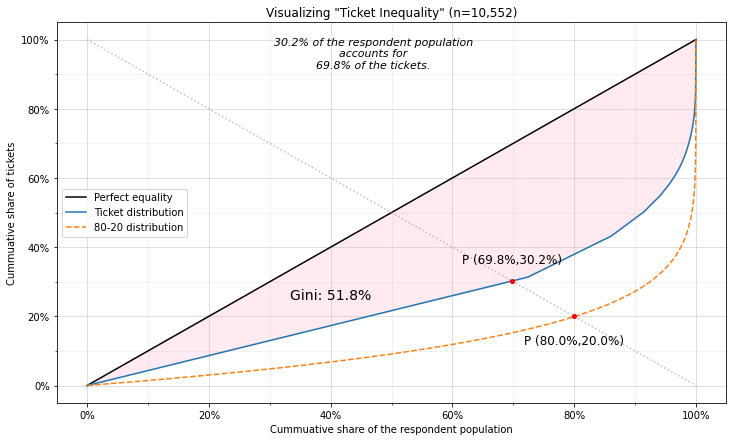

In [44]:
y = df.groupby('respondent_last_name')['ticket_number'].count().reset_index()['ticket_number'].to_numpy()
y.sort()

x = np.arange(0, y.size)
x = x + 1

plot_lorenz_GP(x/x.size,
              y.cumsum()/y.sum(),
              x_measure='respondent',
              y_measure='tickets',
              save_as='lorenz',
              format='pdf')

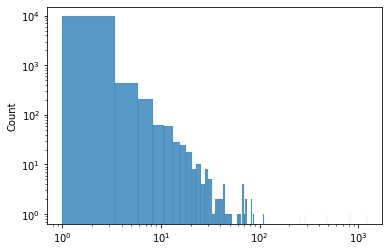

In [45]:
sns.histplot(y, bins=500)
plt.xscale('log')
plt.yscale('log')

In [46]:
# see Eqs 3.1 and 3.2 here
# https://arxiv.org/pdf/0706.1062.pdf

a_hat = 1 + y.size*(np.log(y/(1-0.5)).sum())**-1
print(a_hat)

sigma = (a_hat - 1)/np.sqrt(y.size)

print(sigma)

1.9838052073697647
0.009577269881052399


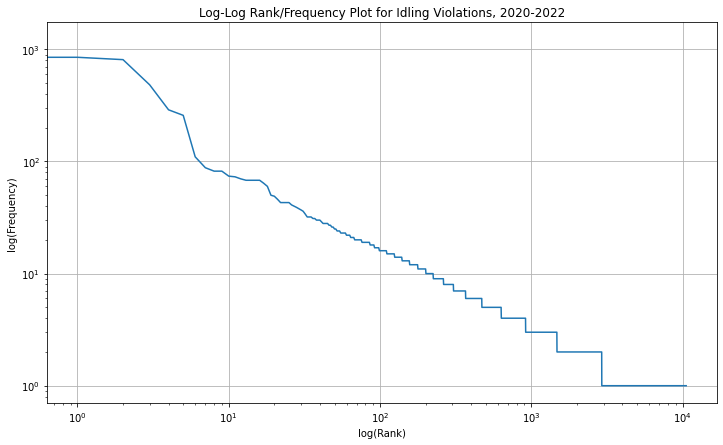

In [47]:
fig, ax = plt.subplots(1, 1)
    
ax.plot(y[::-1])
ax.set_title("Log-Log Rank/Frequency Plot for Idling Violations, 2020-2022")
ax.set_xlabel("log(Rank)")
ax.set_ylabel("log(Frequency)")

ax.grid()

fig = plt.gcf()
fig.set_size_inches(12, 7)

plt.xscale('log')
plt.yscale('log')

fig.savefig('log_log_rank_freq.pdf', dpi=300)

#### Birthday problem — sheet A

In [48]:
# See https://link.springer.com/article/10.1007/s11139-011-9343-9

d = np.arange(1, 5001)

n = np.ceil(np.sqrt(2*d*np.log(2)) + \
             (3 - 2*np.log(2))/6 + \
             (9 - 4*np.log(2)**2)/(72*np.sqrt(2*d*np.log(2))) - \
             2*np.log(2)**2/(135*d))

In [49]:
# pd.Series(n).reset_index()

#### License plates — sheet 6

In [50]:
def estimate_population(m_s, i_s):

    if i_s == 1:
        return 1
    
    y_0 = (i_s - 1)/i_s
    y_n = y_0
    
    for k in range(6):
        y_n_1 = ((m_s - 1)*y_n**m_s - (i_s - 1))/(m_s*y_n**(m_s - 1) - i_s)
        y_n = y_n_1
        
    
    n = math.floor((1 - y_n)**-1)
    
    return n

In [51]:
top_offenders_2020_2022 = (df.groupby('respondent_last_name')['penalty_imposed'].sum()
                             .reset_index()
                             .sort_values(by='penalty_imposed', ascending=False)
                             .head(10)['respondent_last_name']
                             .to_list())

In [52]:
plates_b = pd.pivot_table(df[(df['license_plate'] != 'err') & 
                             (df['respondent_last_name'].isin(top_offenders_2020_2022))], 
                          index='respondent_last_name',
                          values=['license_plate', 
                                  'penalty_imposed'],
                          aggfunc={'license_plate': [len, 'nunique'], 
                                   'penalty_imposed': sum}).droplevel(axis=1, level=0).reset_index()

plates_b.rename({'respondent_last_name' : 'Respondent',
                 'sum': 'penalty_imposed',
                 'len': 'Number of Tickets (complete plates)',
                 'nunique': 'Unique Vehicles'}, axis=1, inplace=True)

plates_b['Pct. Unique'] = plates_b['Unique Vehicles']/plates_b['Number of Tickets (complete plates)']

plates_b = plates_b.sort_values(by='penalty_imposed', ascending=False)

plates_b = plates_b[['Respondent', 'Number of Tickets (complete plates)', 'Unique Vehicles', 'Pct. Unique']]

plates_b['Pop. Estimate (lower bound)'] = plates_b[['Number of Tickets (complete plates)', 
                                      'Unique Vehicles']].apply(lambda x: 
                                                                estimate_population(x['Number of Tickets (complete plates)'], 
                                                                                    x['Unique Vehicles']), 
                                                                axis=1)

plates_c = pd.pivot_table(df[(df['license_plate'] == 'err') & 
                             (df['respondent_last_name'].isin(top_offenders_2020_2022))], 
                          index='respondent_last_name',
                          values=['ticket_number'],
                          aggfunc=len).reset_index()

plates_c.rename({'ticket_number': 'Number of Tickets (incomplete plates)',
                 'respondent_last_name' : 'Respondent',}, axis=1, inplace=True)

plates_b = pd.merge(plates_b, plates_c, on='Respondent', how='left')

plates_b

,Respondent,Number of Tickets (complete plates),Unique Vehicles,Pct. Unique,Pop. Estimate (lower bound),Number of Tickets (incomplete plates)
0,AMAZON,800,262,0.327500,277,50
1,CON ED,1004,547,0.544821,733,214
2,VERIZON,678,351,0.517699,451,132
3,MERCHANT'S FLEET,480,88,0.183333,88,3
4,FEDEX,209,147,0.703349,277,49
5,SPECTRUM,214,155,0.724299,311,75
6,UPS,88,73,0.829545,225,22
7,U-HAUL,76,72,0.947368,687,6
8,EDGE AUTO,62,51,0.822581,151,20
9,GALAXY TOWERS INC,38,9,0.236842,9,3


In [53]:
plates_b.sum()

Respondent                               AMAZONCON EDVERIZONMERCHANT'S FLEETFEDEXSPECTR...
Number of Tickets (complete plates)                                                   3649
Unique Vehicles                                                                       1755
Pct. Unique                                                                       5.837338
Pop. Estimate (lower bound)                                                           3209
Number of Tickets (incomplete plates)                                                  574
dtype: object

#### Actual vs. expected number of repeat tickets — sheet 7

In [54]:
df[df['license_plate'] != 'err']['penalty_imposed'].value_counts().reset_index()

,index,penalty_imposed
0,350,10207
1,1000,6599
2,440,622
3,1500,394
4,600,318
5,2000,200
6,325,1
7,300,1
8,660,1
9,650,1


In [55]:
df['penalty_imposed'].value_counts().reset_index()

,index,penalty_imposed
0,350,13804
1,1000,8906
2,440,698
3,1500,435
4,600,333
5,2000,214
6,750,1
7,351,1
8,163,1
9,250,1


In [56]:
# Vehicles with more than three tickets from 2020 through 2022
plates_c = (df[df['license_plate'] != 'err']
               .groupby('license_plate')['ticket_number']
               .count()
               .reset_index()
               .sort_values(by='ticket_number', ascending=False))

plates_c = plates_c[plates_c['ticket_number'] > 3]

print(plates_c.shape)

repeat_plates = plates_c['license_plate'].to_list()

plates_d = (df[df['license_plate'].isin(repeat_plates)]
              .groupby('fine_type')['ticket_number']
              .count()
              .reset_index())

plates_d['Pct. of Total'] = plates_d['ticket_number']/plates_d['ticket_number'].sum()

plates_d

(389, 2)


,fine_type,ticket_number,Pct. of Total
0,-1,2,0.000738
1,1,2114,0.780074
2,2,249,0.091882
3,3,345,0.127306


In [57]:
# Vehicles with exactly three tickets from 2020 through 2022
plates_c = (df[df['license_plate'] != 'err']
               .groupby('license_plate')['ticket_number']
               .count()
               .reset_index()
               .sort_values(by='ticket_number', ascending=False))

plates_c = plates_c[plates_c['ticket_number'] == 3]

print(plates_c.shape)

repeat_plates = plates_c['license_plate'].to_list()

plates_d = (df[df['license_plate'].isin(repeat_plates)]
              .groupby('fine_type')['ticket_number']
              .count()
              .reset_index())

plates_d['Pct. of Total'] = plates_d['ticket_number']/plates_d['ticket_number'].sum()

plates_d

(454, 2)


,fine_type,ticket_number,Pct. of Total
0,1,1125,0.825991
1,2,158,0.116006
2,3,79,0.058003


In [58]:
# Vehicles with exactly two tickets from 2020 through 2022
plates_c = (df[df['license_plate'] != 'err']
               .groupby('license_plate')['ticket_number']
               .count()
               .reset_index()
               .sort_values(by='ticket_number', ascending=False))

plates_c = plates_c[plates_c['ticket_number'] == 2]

print(plates_c.shape)

repeat_plates = plates_c['license_plate'].to_list()

plates_d = (df[df['license_plate'].isin(repeat_plates)]
              .groupby('fine_type')['ticket_number']
              .count()
              .reset_index())

plates_d['Pct. of Total'] = plates_d['ticket_number']/plates_d['ticket_number'].sum()

plates_d

(1732, 2)


,fine_type,ticket_number,Pct. of Total
0,1,3084,0.890300
1,2,323,0.093245
2,3,57,0.016455


In [59]:
# Vehicles with exactly one ticket from 2020 through 2022
plates_c = (df[(df['license_plate'] != 'err')]
               .groupby('license_plate')['ticket_number']
               .count()
               .reset_index()
               .sort_values(by='ticket_number', ascending=False))

plates_c = plates_c[plates_c['ticket_number'] == 1]

print(plates_c.shape)

repeat_plates = plates_c['license_plate'].to_list()

plates_d = (df[df['license_plate'].isin(repeat_plates)]
              .groupby('fine_type')['ticket_number']
              .count()
              .reset_index())

plates_d['Pct. of Total'] = plates_d['ticket_number']/plates_d['ticket_number'].sum()

plates_d

(10808, 2)


,fine_type,ticket_number,Pct. of Total
0,-1,2,0.000185
1,1,10483,0.969930
2,2,286,0.026462
3,3,37,0.003423


In [60]:
df[df['respondent_last_name'].isin(top_offenders_2020_2022)].groupby('fine_type')['ticket_number'].count().reset_index()



,fine_type,ticket_number
0,-1,2
1,1,3671
2,2,303
3,3,247


#### Offenses by state — sheet 8

In [61]:
plates_a = pd.pivot_table(df.query("license_plate != 'err'"), 
                          index='license_plate_state',
                          values=['license_plate', 
                                  'penalty_imposed'],
                          aggfunc={'license_plate': [len, 'nunique'], 
                                   'penalty_imposed': sum}).droplevel(axis=1, level=0).reset_index()

plates_a.rename({'license_plate_state' : 'Vehicle State',
                 'sum': 'penalty_imposed',
                 'len': 'Number of Tickets',
                 'nunique': 'Unique Vehicles'}, axis=1, inplace=True)

plates_a['Pct. Unique'] = plates_a['Unique Vehicles']/plates_a['Number of Tickets']

plates_a = plates_a[['Vehicle State', 'Number of Tickets', 'Unique Vehicles', 'Pct. Unique', 'penalty_imposed']]

plates_a.sort_values(by='Number of Tickets', ascending=False).head(15)

,Vehicle State,Number of Tickets,Unique Vehicles,Pct. Unique,penalty_imposed
32,NY,12198,9148,0.749959,7504095
30,NJ,3753,2661,0.709033,2490200
8,FL,732,143,0.195355,585350
14,IN,477,395,0.828092,266590
36,PA,196,168,0.857143,130330
13,IL,174,145,0.833333,106810
39,TX,116,98,0.844828,85130
5,CT,91,84,0.923077,50300
2,AZ,89,87,0.977528,63000
19,MD,81,62,0.765432,53110


In [62]:
plates_a.sum()

Vehicle State        ALARAZCACOCTDCDEFLGAHIIAIDILINKSKYLAMAMDMEMIML...
Number of Tickets                                                18344
Unique Vehicles                                                  13383
Pct. Unique                                                  39.031572
penalty_imposed                                               11628865
dtype: object

In [63]:
df.query("license_plate == 'err'").shape

(6055, 74)

In [64]:
(df[(df['license_plate'] != 'err') & (df['violation_year'] == 2022)]
   .groupby('license_plate')['ticket_number']
   .count()
   .reset_index()
   .sort_values(by='ticket_number', ascending=False)
   .head(10))

,license_plate,ticket_number
42,FL_QEGB73,29
24,FL_15AAIW,22
366,NJ_XLSD87,18
34,FL_86AYPS,17
45,FL_QIAE15,12
859,NY_52114BB,11
28,FL_57ABEG,11
36,FL_QBXE28,10
39,FL_QEFS41,10
47,FL_QIAM21,10


In [65]:
(df[df['license_plate'] == 'FL_15AAIW']
 .sort_values(by='violation_date')[['violation_date', 'penalty_imposed']]
 .reset_index())

,index,violation_date,penalty_imposed
0,30106,2021-06-02,350
1,29911,2021-06-07,1000
2,30007,2021-06-30,1000
3,30210,2021-07-03,1000
4,30131,2021-07-15,1000
5,30021,2021-07-16,1000
6,28038,2021-07-22,1000
7,27329,2021-11-19,350
8,27626,2021-11-30,1000
9,28111,2021-12-07,350


#### Penalty imposed value counts by respondent — sheet 9

In [66]:
comps = (pd.pivot_table(df, 
                        index='respondent_last_name', 
                        values=['penalty_imposed', 'paid_amount', 'ticket_number'],
                        aggfunc={'penalty_imposed': sum, 'paid_amount': sum, 'ticket_number': len})
           .reset_index())

comps.sort_values(by='penalty_imposed', ascending=False, inplace=True)

In [67]:
for r in comps.iloc[:10]['respondent_last_name'].values:
    print(r)
    display(df[df['respondent_last_name'] == r]['penalty_imposed'].value_counts().reset_index())

AMAZON


,index,penalty_imposed
0,1000,712
1,1500,72
2,2000,46
3,350,19
4,440,1


CON ED


,index,penalty_imposed
0,350,756
1,1000,282
2,440,69
3,600,55
4,2000,31
5,1500,25


VERIZON


,index,penalty_imposed
0,350,653
1,440,67
2,600,62
3,1000,21
4,1500,4
5,250,1
6,2000,1
7,650,1


MERCHANT'S FLEET


,index,penalty_imposed
0,350,420
1,600,36
2,440,16
3,1000,11


FEDEX


,index,penalty_imposed
0,350,175
1,1000,70
2,440,10
3,1500,2
4,2000,1


SPECTRUM


,index,penalty_imposed
0,350,264
1,440,13
2,600,11
3,1000,1


UPS


,index,penalty_imposed
0,1000,79
1,350,23
2,440,3
3,1500,3
4,2000,2


EDGE AUTO


,index,penalty_imposed
0,1000,41
1,350,33
2,1500,4
3,440,3
4,2000,1


U-HAUL


,index,penalty_imposed
0,1000,42
1,350,38
2,1500,2


GALAXY TOWERS INC


,index,penalty_imposed
0,1000,31
1,1500,9
2,2000,1
